# 🎯 Semantic Entropy

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
   Black-box Uncertainty Quantification (UQ) methods treat the LLM as a black box and evaluate consistency of multiple responses generated from the same prompt to estimate response-level confidence. This demo provides an illustration of a state-of-the-art black-box UQ method known as Semantic Entropy.
  </p>
</div>
      
## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>SemanticEntropy()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Visualize model accuracy at different thresholds of the various black-box UQ confidence scores. Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM</li>
      <li><strong>Intuitive:</strong> Easy to understand and implement</li>
      <li><strong>No Internal Access Required:</strong> Doesn't need token probabilities or model internals</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
    </ul>
  </div>
</div>

In [1]:
import os

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner
from uqlm import SemanticEntropy

/Users/c767873/Library/Caches/pypoetry/virtualenvs/uqlm-m1pshusV-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of math questions from the [SVAMP benchmark](https://arxiv.org/abs/2103.07191). To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (SVAMP)
svamp = load_example_dataset("svamp", n=100)
svamp.head()

Loading dataset - svamp...
Processing dataset...
Dataset ready!


,question,answer
0,There are 87 oranges and 290 bananas in Philip...,145
1,Marco and his dad went strawberry picking. Mar...,19
2,Edward spent $ 6 to buy 2 books each book cost...,3
3,Frank was reading through his favorite book. T...,198
4,There were 78 dollars in Olivia's wallet. She ...,63


In [3]:
# Define prompts
MATH_INSTRUCTION = "When you solve this math problem only return the answer with no additional text.\n"
prompts = [MATH_INSTRUCTION + prompt for prompt in svamp.question]

In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [4]:
# import sys
# !{sys.executable} -m pip install python-dotenv
# !{sys.executable} -m pip install langchain-openai

# # User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(
    deployment_name=os.getenv("DEPLOYMENT_NAME"),
    openai_api_key=os.getenv("API_KEY"),
    azure_endpoint=os.getenv("API_BASE"),
    openai_api_type=os.getenv("API_TYPE"),
    openai_api_version=os.getenv("API_VERSION"),
    temperature=1,  # User to set temperature
)

<a id='section2'></a>
## 2. Generate responses and confidence scores

### `SemanticEntropy()` - Generate LLM responses and compute consistency-based confidence scores for each response.

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">device</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or torch.device<br><code>default="cpu"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the device that NLI model use for prediction. Only applies to 'semantic_negentropy', 'noncontradiction' scorers. Pass a torch.device to leverage GPU.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_best</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=True</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to swap the original response for the uncertainty-minimized response among all sampled responses based on semantic entropy clusters. Only used if `scorers` includes 'semantic_negentropy' or 'noncontradiction'.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_n_param</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to use <code>n</code> parameter for <code>BaseChatModel</code>. Not compatible with all <code>BaseChatModel</code> classes. If used, it speeds up the generation process substantially when <code>num_responses</code> is large.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">postprocessor</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">callable<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A user-defined function that takes a string input and returns a string. Used for postprocessing outputs.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM model to generate sampled LLM responses. Must be greater than 0.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_model_name</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="microsoft/deberta-large-mnli"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which NLI model to use. Must be acceptable input to <code>AutoTokenizer.from_pretrained()</code> and <code>AutoModelForSequenceClassification.from_pretrained()</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_length</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=2000</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the maximum allowed string length for LLM responses for NLI computation. Responses longer than this value will be truncated in NLI computations to avoid <code>OutOfMemoryError</code>.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>nli_model_name</code></li>
      <li><code>use_best</code></li>
      <li><code>postprocessor</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 150, 0, 0.1); border-radius: 5px; border: 1px solid rgba(200, 150, 0, 0.2);">
    <p style="font-weight: bold">🖥️ Hardware</p>
    <ul>
      <li><code>device</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
      <li><code>use_n_param</code></li>
    </ul>
  </div>
</div>

#### 💻 Usage Examples

```python
# Basic usage with default parameters
se = SemanticEntropy(llm=llm)

# Using GPU acceleration, default scorers
se = SemanticEntropy(llm=llm, device=torch.device("cuda"))

# High-throughput configuration with rate limiting
se = SemanticEntropy(llm=llm, max_calls_per_min=200, use_n_param=True) 
```

In [5]:
import torch

# Set the torch device
if torch.cuda.is_available():  # NVIDIA GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # macOS
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # CPU
print(f"Using {device.type} device")

Using mps device


In [6]:
se = SemanticEntropy(
    llm=llm,
    max_calls_per_min=250,  # set value to avoid rate limit error
    device=device,  # use if GPU available
)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">SemanticEntropy.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses, sampled LLM (candidate) responses, and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>list of str</strong>) A list of input prompts for the model.</li>
        <li><code>num_responses</code> - (<strong>int, default=5</strong>) The number of sampled responses used to compute consistency.</li>
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">SemanticEntropy.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute confidence scores on provided LLM responses. Should only be used if responses and sampled responses are already generated.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>responses</code> - (<strong>list of str</strong>) A list of LLM responses for the prompts.</li>
        <li><code>sampled_responses</code> - (<strong>list of list of str</strong>) A list of lists of sampled LLM responses for each prompt. These will be used to compute consistency scores by comparing to the corresponding response from <code>responses</code>.</li>
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [7]:
results = await se.generate_and_score(prompts=prompts, num_responses=10)

# # alternative approach: directly score if responses already generated
# results = se.score(responses=responses, sampled_responses=sampled_responses)

UQLM: Using logprobs to compute response probabilities for semantic entropy score
Generating responses...
Generating candidate responses...
Computing confidence scores...


The LLM instance used here, returns token probabilities during the response generation. In such scenario, `SemanticEntropy` class computes response probabilty in two ways: 1) Discrete Semantic Entropy: Equal probability to each sampled response and 2) Uses token probability to compute probability of each sampled response. The final results contains semantic entropy scores based on both approach

Note: When token probabilities are avaliable `best_response` is returned based on token probability based Semantic Entropy scores.

In [8]:
result_df = results.to_df()
result_df.head(5)

,response,entropy_value,confidence_score,sampled_responses,prompt,tokenprob_entropy_value,tokenprob_confidence_score
0,145,0.0,1.0,"[145, 145, 145, 145, 145, 145, 145, 145, 145, ...",When you solve this math problem only return t...,0.0,1.0
1,19 pounds,0.0,1.0,"[19 pounds, 19 pounds, 19 pounds, 19 pounds., ...",When you solve this math problem only return t...,0.0,1.0
2,$3,0.0,1.0,"[$3, 3, $3, $3, 3, $3, $3, 3, 3, $3]",When you solve this math problem only return t...,0.0,1.0
3,198,0.0,1.0,"[198, 198, 198, 198, 198, 198, 198, 198, 198, ...",When you solve this math problem only return t...,0.0,1.0
4,63,0.0,1.0,"[63, 63, 63, 63, 63, 63, 63, 63, 63, 63]",When you solve this math problem only return t...,0.0,1.0


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. Note the `math_postprocessor` is specific to our use case (math questions). **If you are using your own prompts/questions, update the grading method accordingly**.

In [9]:
# Populate correct answers and grade responses
result_df["answer"] = svamp.answer
result_df["response_correct"] = [math_postprocessor(r) == a for r, a in zip(result_df["response"], svamp["answer"])]
result_df.head(5)

,response,entropy_value,confidence_score,sampled_responses,prompt,tokenprob_entropy_value,tokenprob_confidence_score,answer,response_correct
0,145,0.0,1.0,"[145, 145, 145, 145, 145, 145, 145, 145, 145, ...",When you solve this math problem only return t...,0.0,1.0,145,True
1,19 pounds,0.0,1.0,"[19 pounds, 19 pounds, 19 pounds, 19 pounds., ...",When you solve this math problem only return t...,0.0,1.0,19,True
2,$3,0.0,1.0,"[$3, 3, $3, $3, 3, $3, $3, 3, 3, $3]",When you solve this math problem only return t...,0.0,1.0,3,True
3,198,0.0,1.0,"[198, 198, 198, 198, 198, 198, 198, 198, 198, ...",When you solve this math problem only return t...,0.0,1.0,198,True
4,63,0.0,1.0,"[63, 63, 63, 63, 63, 63, 63, 63, 63, 63]",When you solve this math problem only return t...,0.0,1.0,63,True


In [10]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.88


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our confidence scores. Filtered accuracy measures the change in LLM performance when responses with confidence scores below a specified threshold are excluded. By adjusting the confidence score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various confidence score thresholds to visualize the relationship between confidence and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. 

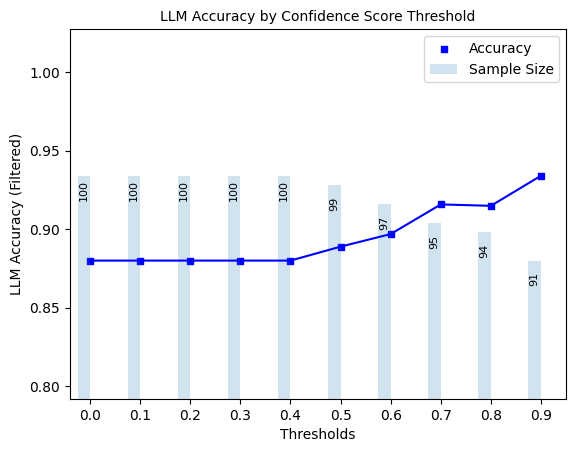

In [11]:
plot_model_accuracies(scores=result_df.confidence_score, correct_indicators=result_df.response_correct)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we compute precision, recall, and F1-score for black box scorer predictions of whether responses are correct.

In [12]:
# instantiate UQLM tuner object for threshold selection
t = Tuner()

# Define score vector and corresponding correct indicators (i.e. ground truth)
y_scores = result_df["confidence_score"]  # confidence score
correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct

# Solve for threshold that maximizes F1-score
best_threshold = t.tune_threshold(y_scores=y_scores, correct_indicators=correct_indicators, thresh_objective="fbeta_score")
y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
print(f"Semantic entropy F1-optimal threshold: {best_threshold}")

Semantic entropy F1-optimal threshold: 0.65


In [13]:
# evaluate precision, recall, and f1-score of semantic entropy predictions of correctness
print(f"Semantic entropy precision: {precision_score(y_true=correct_indicators, y_pred=y_pred)}")
print(f"Semantic entropy recall: {recall_score(y_true=correct_indicators, y_pred=y_pred)}")
print(f"Semantic entropy f1-score: {f1_score(y_true=correct_indicators, y_pred=y_pred)}")

Semantic entropy precision: 0.9157894736842105
Semantic entropy recall: 0.9886363636363636
Semantic entropy f1-score: 0.9508196721311475


© 2025 CVS Health and/or one of its affiliates. All rights reserved.